# Understanding and Detecting Model Drift


This notebook provides a hands-on demonstration of **model drift**, a critical concept in machine learning operations (MLOps). We will explore what model drift is, why it occurs, and how to detect it using Python libraries.

## Learning Objectives

By the end of this notebook, you will be able to:
1. Understand what model drift is and why it matters
2. Distinguish between different types of drift
3. Simulate drift in a data stream
4. Implement drift detection algorithms
5. Visualize and interpret drift detection results

## 1. What is Model Drift?

**Model drift**, also known as **model decay**, refers to the degradation of a machine learning model's performance over time. This phenomenon occurs when the statistical properties of the data the model encounters in production diverge from the data it was trained on.

### Why Does Model Drift Matter?

When model drift occurs, the model's predictions become less accurate, leading to:
- Poor decision-making
- Decreased business value
- Potential financial losses
- Reduced user trust

### Real-World Example

Consider a credit card fraud detection model trained on data from 2020. As fraudsters develop new techniques in 2021 and beyond, the patterns of fraudulent transactions change. The model, still operating on 2020 patterns, begins to miss new types of fraud—this is model drift in action.

## 2. Types of Model Drift

There are three main types of drift that can affect machine learning models:

### 2.1 Concept Drift

**Concept drift** occurs when the relationship between the input variables (features) and the target variable changes over time. In mathematical terms, the conditional probability P(Y|X) changes, where Y is the target and X represents the features.

**Example:** In a spam email classifier, what constitutes "spam" evolves as spammers adapt their tactics. An email pattern that was spam yesterday might be legitimate today, or vice versa.

**Types of Concept Drift:**
- **Sudden (Abrupt):** A rapid change in the relationship (e.g., COVID-19 pandemic impact on consumer behavior)
- **Gradual:** Slow evolution over time (e.g., changing fashion trends)
- **Incremental:** Step-by-step changes
- **Recurring (Seasonal):** Patterns that repeat periodically (e.g., holiday shopping patterns)

### 2.2 Data Drift (Covariate Shift)

**Data drift** happens when the statistical distribution of the input features changes, but the relationship between features and target remains constant. In mathematical terms, P(X) changes, but P(Y|X) stays the same.

**Example:** A house price prediction model trained on urban data is deployed in a rural area. The distribution of features (house size, lot size, etc.) is different, even though the relationship between these features and price remains similar.

### 2.3 Upstream Data Changes

**Upstream data changes** occur when modifications in the data pipeline affect the data quality or format.

**Examples:**
- Change in measurement units (miles to kilometers)
- Change in data collection methods
- Software updates that alter feature engineering
- Changes in data sources

## 3. Setting Up Our Environment

Let's import the necessary libraries for our drift detection demonstration.

In [4]:
!uv pip install river

Using Python 3.12.11 environment at: /Users/tarekatwan/Repos/MyWork/Teach/repos/adv_ml_ds/dev1
Audited 1 package in 2ms


In [5]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from river import drift
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
NumPy version: 2.3.4


## 4. Simulating Data Drift

To understand drift detection, we'll first create a synthetic data stream that contains a drift point. This will help us visualize what drift looks like and test our detection algorithms.

### Scenario

Imagine we're monitoring a sensor that measures temperature. Initially, the sensor reads values around 20°C (68°F). After some time, due to environmental changes or sensor calibration issues, the readings shift to around 25°C (77°F).

In [6]:
# Generate synthetic data stream with drift

# Stream 1: Initial distribution (mean=20, std=2)
stream_1 = np.random.normal(20, 2, 500)

# Stream 2: Drifted distribution (mean=25, std=2.5)
stream_2 = np.random.normal(25, 2.5, 500)

# Concatenate to create a single stream with drift at index 500
data_stream = np.concatenate((stream_1, stream_2))

print(f"Total data points: {len(data_stream)}")
print(f"Stream 1 - Mean: {stream_1.mean():.2f}, Std: {stream_1.std():.2f}")
print(f"Stream 2 - Mean: {stream_2.mean():.2f}, Std: {stream_2.std():.2f}")
print(f"\nDrift introduced at index: 500")

Total data points: 1000
Stream 1 - Mean: 20.01, Std: 1.96
Stream 2 - Mean: 25.08, Std: 2.44

Drift introduced at index: 500


### Visualizing the Data Stream

Let's plot our data stream to see the drift visually. The red vertical line indicates where we introduced the drift.

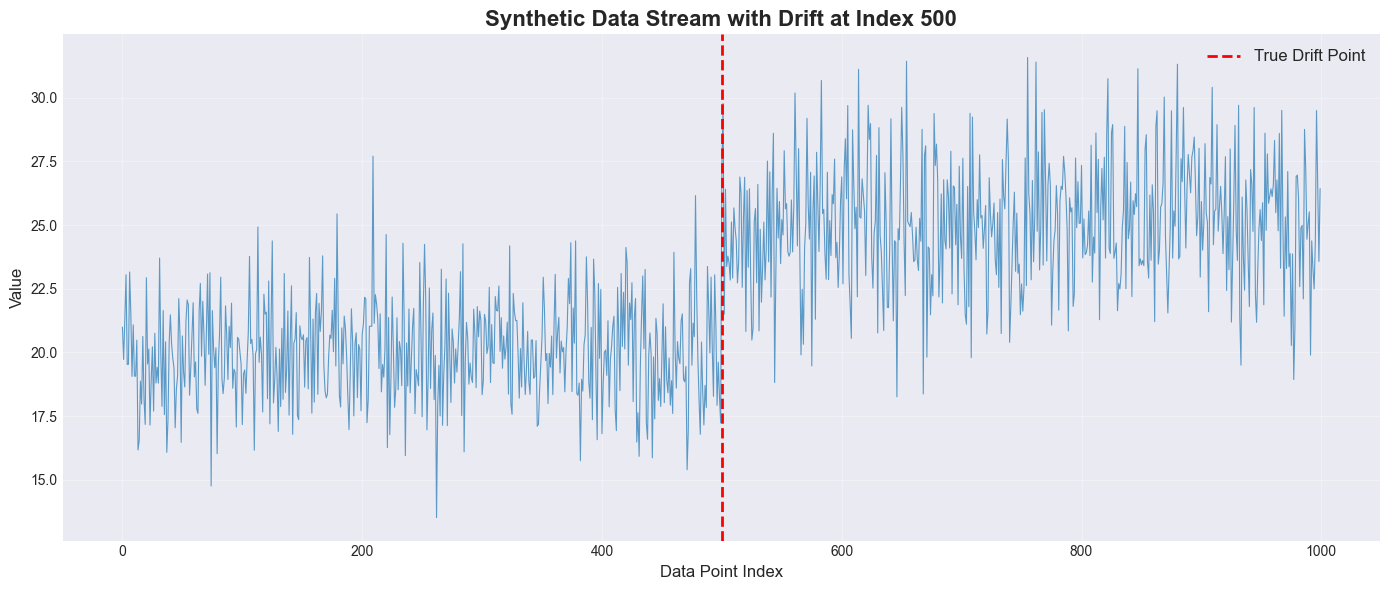

Notice how the data values shift upward after index 500.
This represents a sudden drift in the data distribution.


In [7]:
# Plot the data stream
plt.figure(figsize=(14, 6))
plt.plot(data_stream, alpha=0.7, linewidth=0.8)
plt.axvline(x=500, color='red', linestyle='--', linewidth=2, label='True Drift Point')
plt.title('Synthetic Data Stream with Drift at Index 500', fontsize=16, fontweight='bold')
plt.xlabel('Data Point Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Notice how the data values shift upward after index 500.")
print("This represents a sudden drift in the data distribution.")

## 5. Drift Detection with ADWIN

Now we'll use a drift detection algorithm to automatically identify the drift point. We'll use **ADWIN (ADaptive WINdowing)**, a popular algorithm for detecting changes in data streams.

### How ADWIN Works

ADWIN maintains a sliding window of recent data points and continuously checks if the distribution in the window has changed significantly. When it detects a change, it signals a drift and adjusts the window size.

**Key Features:**
- No need to set a fixed window size
- Adapts to the rate of change
- Provides rigorous guarantees on false positive rates
- Effective for both sudden and gradual drifts

In [9]:
# Initialize the ADWIN drift detector
adwin = drift.ADWIN()

# Track detected drift points
drift_points = []

# Process the stream and detect drift
print("Processing data stream...\n")

for i, value in enumerate(data_stream):
    # Update the detector with the new value
    adwin.update(value)
    
    # Check if drift was detected
    if adwin.drift_detected:
        print(f"Drift detected at index: {i}")
        drift_points.append(i)

print(f"\nTotal drift points detected: {len(drift_points)}")
print(f"Detected drift points: {drift_points}")

Processing data stream...

Drift detected at index: 511

Total drift points detected: 1
Detected drift points: [511]


### Visualizing Detected Drift

Let's visualize the data stream along with the detected drift points.

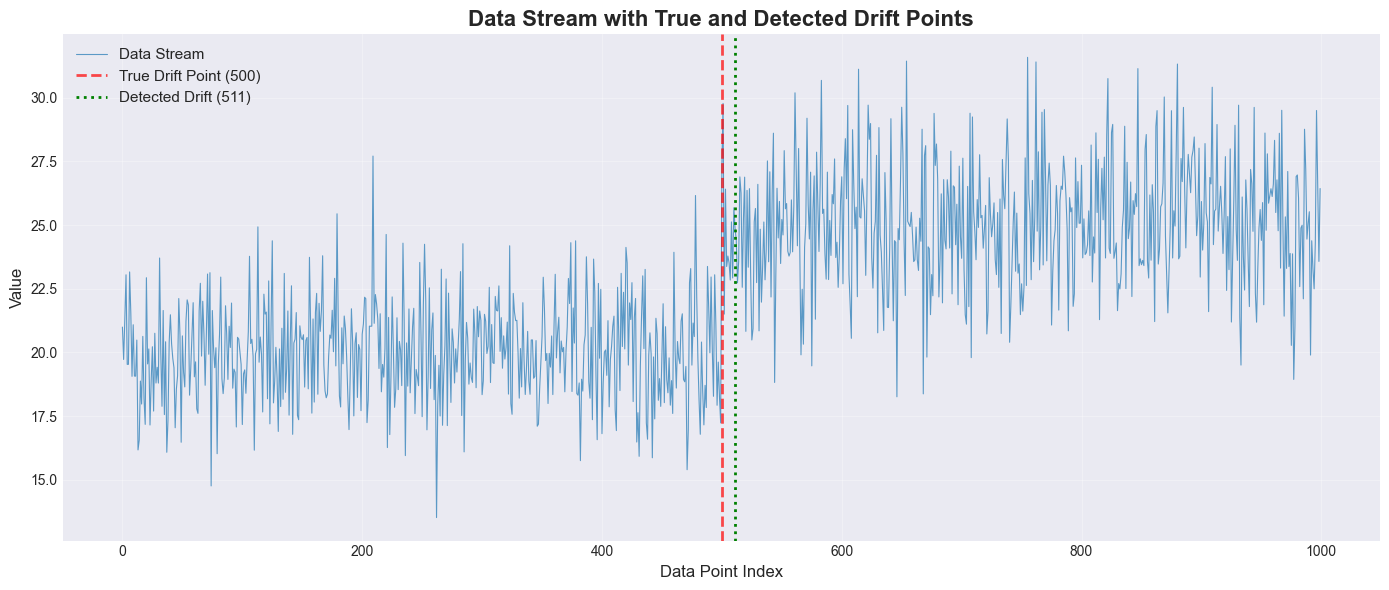


Detection Performance:
  - True drift point: 500
  - First detected drift: 511
  - Detection delay: 11 data points


In [10]:
# Plot the stream with detected drift points
plt.figure(figsize=(14, 6))
plt.plot(data_stream, alpha=0.7, linewidth=0.8, label='Data Stream')
plt.axvline(x=500, color='red', linestyle='--', linewidth=2, label='True Drift Point (500)', alpha=0.7)

# Mark detected drift points
for idx, drift_point in enumerate(drift_points):
    if idx == 0:
        plt.axvline(x=drift_point, color='green', linestyle=':', linewidth=2, 
                   label=f'Detected Drift ({drift_point})')
    else:
        plt.axvline(x=drift_point, color='green', linestyle=':', linewidth=2)

plt.title('Data Stream with True and Detected Drift Points', fontsize=16, fontweight='bold')
plt.xlabel('Data Point Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate detection accuracy
if drift_points:
    detection_delay = drift_points[0] - 500
    print(f"\nDetection Performance:")
    print(f"  - True drift point: 500")
    print(f"  - First detected drift: {drift_points[0]}")
    print(f"  - Detection delay: {detection_delay} data points")
else:
    print("\nNo drift was detected by the algorithm.")

## 6. Experimenting with Gradual Drift

Let's create a more challenging scenario: **gradual drift**. Instead of an abrupt change, the data distribution shifts slowly over time.

In [11]:
# Create a gradual drift scenario
np.random.seed(42)

# Initial stable period
stable_data = np.random.normal(20, 2, 300)

# Gradual transition period (300 points)
transition_length = 300
transition_data = []
for i in range(transition_length):
    # Gradually shift mean from 20 to 25
    current_mean = 20 + (5 * i / transition_length)
    # Gradually increase std from 2 to 2.5
    current_std = 2 + (0.5 * i / transition_length)
    transition_data.append(np.random.normal(current_mean, current_std))

transition_data = np.array(transition_data)

# New stable period
new_stable_data = np.random.normal(25, 2.5, 400)

# Combine all periods
gradual_stream = np.concatenate([stable_data, transition_data, new_stable_data])

print(f"Gradual drift stream created:")
print(f"  - Stable period 1: 0-299 (mean ≈ 20)")
print(f"  - Transition period: 300-599 (mean shifts from 20 to 25)")
print(f"  - Stable period 2: 600-999 (mean ≈ 25)")

Gradual drift stream created:
  - Stable period 1: 0-299 (mean ≈ 20)
  - Transition period: 300-599 (mean shifts from 20 to 25)
  - Stable period 2: 600-999 (mean ≈ 25)


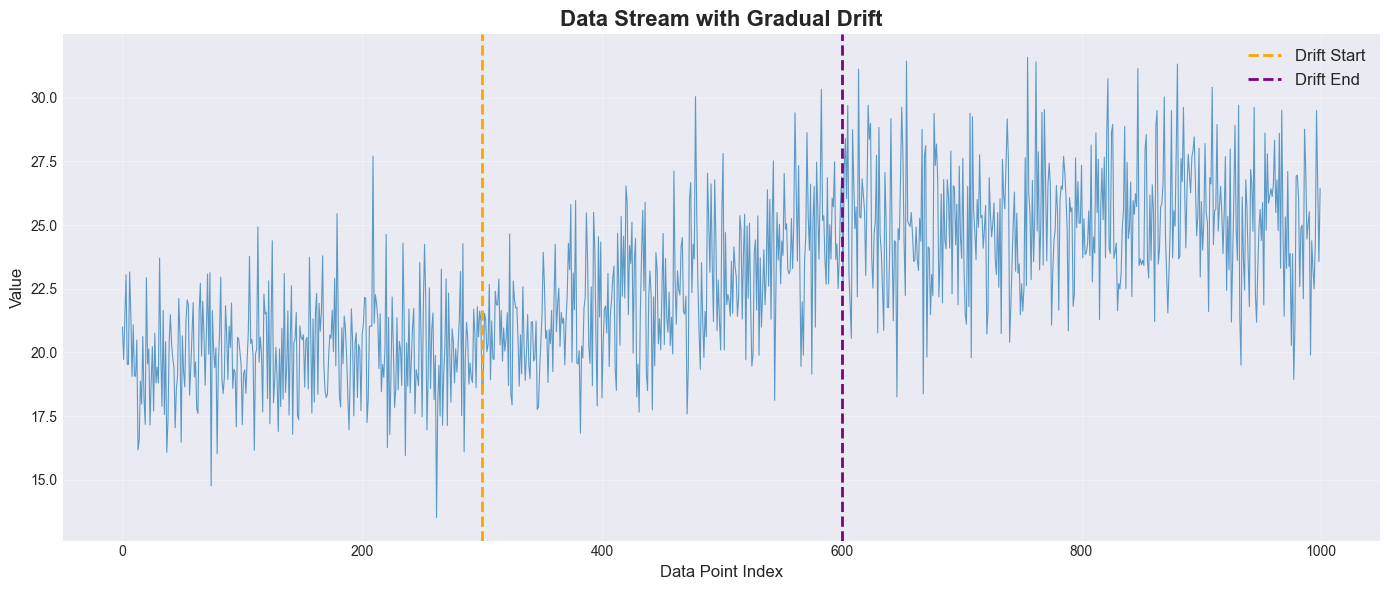

In [12]:
# Visualize gradual drift
plt.figure(figsize=(14, 6))
plt.plot(gradual_stream, alpha=0.7, linewidth=0.8)
plt.axvline(x=300, color='orange', linestyle='--', linewidth=2, label='Drift Start')
plt.axvline(x=600, color='purple', linestyle='--', linewidth=2, label='Drift End')
plt.title('Data Stream with Gradual Drift', fontsize=16, fontweight='bold')
plt.xlabel('Data Point Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Detecting Gradual Drift

In [13]:
# Detect drift in gradual stream
adwin_gradual = drift.ADWIN()
gradual_drift_points = []

print("Detecting gradual drift...\n")

for i, value in enumerate(gradual_stream):
    adwin_gradual.update(value)
    if adwin_gradual.drift_detected:
        print(f"Drift detected at index: {i}")
        gradual_drift_points.append(i)

print(f"\nTotal drift points detected: {len(gradual_drift_points)}")

Detecting gradual drift...

Drift detected at index: 415
Drift detected at index: 607

Total drift points detected: 2


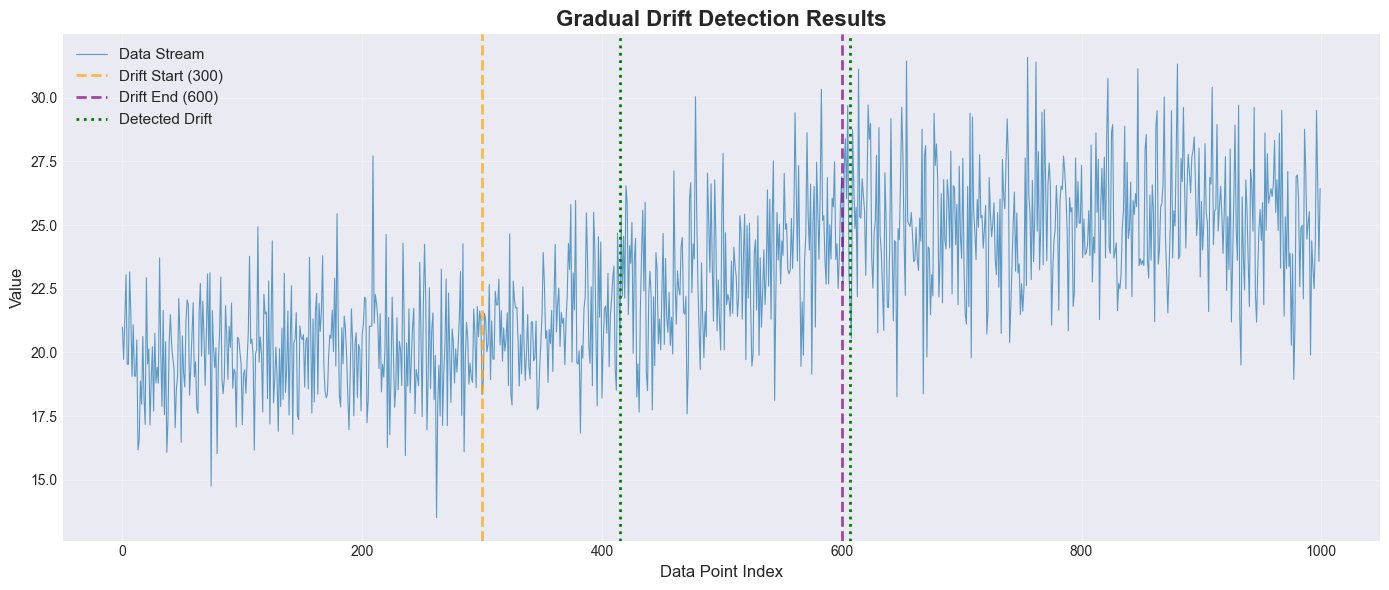


Observation: Gradual drift is harder to detect and may trigger multiple alerts.
The detector identifies changes throughout the transition period.


In [14]:
# Visualize gradual drift detection
plt.figure(figsize=(14, 6))
plt.plot(gradual_stream, alpha=0.7, linewidth=0.8, label='Data Stream')
plt.axvline(x=300, color='orange', linestyle='--', linewidth=2, label='Drift Start (300)', alpha=0.7)
plt.axvline(x=600, color='purple', linestyle='--', linewidth=2, label='Drift End (600)', alpha=0.7)

for idx, drift_point in enumerate(gradual_drift_points):
    if idx == 0:
        plt.axvline(x=drift_point, color='green', linestyle=':', linewidth=2, 
                   label=f'Detected Drift')
    else:
        plt.axvline(x=drift_point, color='green', linestyle=':', linewidth=2)

plt.title('Gradual Drift Detection Results', fontsize=16, fontweight='bold')
plt.xlabel('Data Point Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObservation: Gradual drift is harder to detect and may trigger multiple alerts.")
print("The detector identifies changes throughout the transition period.")

## 7. Comparing Different Drift Detectors

The `river` library provides several drift detection algorithms. Let's compare ADWIN with another popular detector: **DDM (Drift Detection Method)**.

### DDM (Drift Detection Method)

DDM monitors the error rate of an online learner. It's based on the assumption that the error rate will increase when drift occurs. DDM is particularly effective for classification problems.

In [15]:
# Simulate a classification scenario with drift
np.random.seed(42)

# Before drift: model has 10% error rate
errors_before = np.random.choice([0, 1], size=500, p=[0.9, 0.1])

# After drift: model has 30% error rate (performance degraded)
errors_after = np.random.choice([0, 1], size=500, p=[0.7, 0.3])

# Combine error streams
error_stream = np.concatenate([errors_before, errors_after])

print(f"Classification error stream created:")
print(f"  - Before drift (0-499): ~10% error rate")
print(f"  - After drift (500-999): ~30% error rate")
print(f"  - Actual error rate before: {errors_before.mean()*100:.1f}%")
print(f"  - Actual error rate after: {errors_after.mean()*100:.1f}%")

Classification error stream created:
  - Before drift (0-499): ~10% error rate
  - After drift (500-999): ~30% error rate
  - Actual error rate before: 11.0%
  - Actual error rate after: 26.8%


In [16]:
# Use DDM to detect drift
ddm = drift.DDM()
ddm_drift_points = []
ddm_warning_points = []

print("\nDetecting drift with DDM...\n")

for i, error in enumerate(error_stream):
    # DDM expects binary input (0 = correct, 1 = error)
    ddm.update(error)
    
    if ddm.drift_detected:
        print(f"Drift detected at index: {i}")
        ddm_drift_points.append(i)

print(f"\nTotal drift points detected by DDM: {len(ddm_drift_points)}")

AttributeError: module 'river.drift' has no attribute 'DDM'

NameError: name 'ddm_drift_points' is not defined

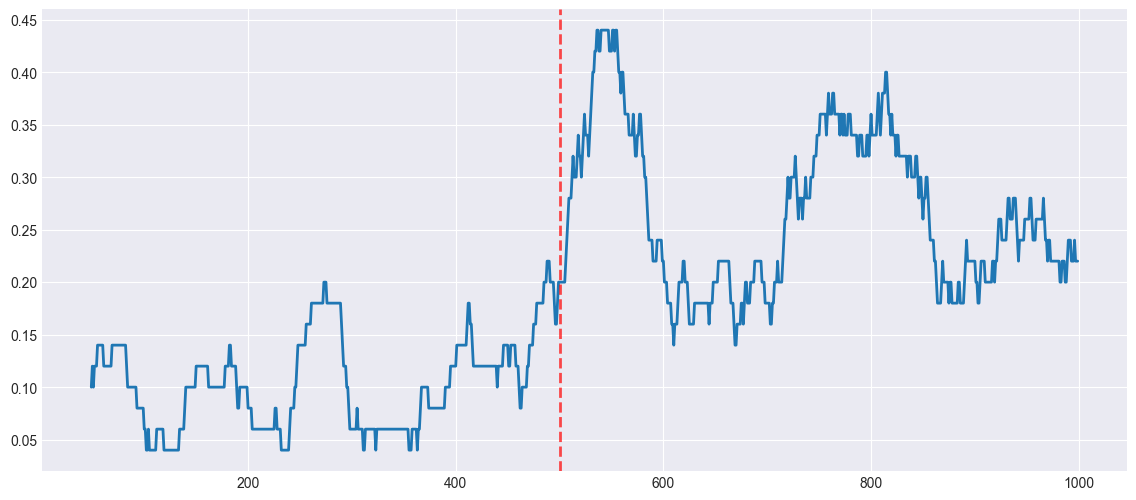

In [17]:
# Visualize error rates and detected drift
# Calculate moving average of errors for visualization
window_size = 50
moving_avg = np.convolve(error_stream, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(14, 6))
plt.plot(range(window_size-1, len(error_stream)), moving_avg, 
         linewidth=2, label='Error Rate (Moving Average)')
plt.axvline(x=500, color='red', linestyle='--', linewidth=2, 
           label='True Drift Point (500)', alpha=0.7)

for idx, drift_point in enumerate(ddm_drift_points):
    if idx == 0:
        plt.axvline(x=drift_point, color='green', linestyle=':', linewidth=2, 
                   label=f'DDM Detected Drift')
    else:
        plt.axvline(x=drift_point, color='green', linestyle=':', linewidth=2)

plt.title('Drift Detection in Classification Error Stream (DDM)', fontsize=16, fontweight='bold')
plt.xlabel('Data Point Index', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nDDM is particularly effective for detecting drift in classification performance.")

## 8. Key Takeaways and Best Practices

### Summary

In this notebook, we've explored:

1. **What model drift is**: The degradation of model performance over time due to changes in data
2. **Types of drift**: Concept drift, data drift, and upstream data changes
3. **Drift patterns**: Sudden, gradual, incremental, and recurring drift
4. **Detection methods**: ADWIN for general drift detection and DDM for classification scenarios
5. **Practical implementation**: How to use the `river` library to detect drift in Python

### Best Practices for Production Systems

1. **Monitor Continuously**: Set up automated drift detection in your ML pipelines
2. **Choose Appropriate Detectors**: Select algorithms based on your data type and drift patterns
3. **Set Thresholds Carefully**: Balance between false positives and detection delay
4. **Combine Multiple Signals**: Use both performance metrics and drift detectors
5. **Establish Retraining Protocols**: Have a plan for when drift is detected
6. **Log and Analyze**: Keep records of detected drifts for pattern analysis
7. **Test Drift Scenarios**: Simulate different types of drift during model development

### When to Retrain Your Model

Consider retraining when:
- Drift is detected consistently over multiple periods
- Model performance metrics drop below acceptable thresholds
- Business metrics (e.g., conversion rates) are affected
- Major events occur that likely affect your domain (e.g., regulatory changes)

### Additional Resources

- **River Documentation**: https://riverml.xyz/
- **Evidently AI**: Another excellent library for ML monitoring
- **Research Papers**: Look up "concept drift detection" on Google Scholar
- **MLOps Practices**: Study continuous training and monitoring patterns